### Import section

In [42]:
from mongoengine import connect, disconnect
from settings import DevelopmentConfig, TestingConfig
from tests.factories.marketplace import UserFactory, ServiceFactory
import random


from recommender.engine.pre_agent.preprocessing.mongo_to_dataframe import (
    create_raw_dataset,
    USERS,
    SERVICES,
    LABELS,
    calculate_dfs_for_users_and_services
)
from recommender.engine.pre_agent.preprocessing.dataframe_to_tensor import (
    raw_dataset_to_tensors,
    calculate_tensors_for_users_and_services,
    user_and_service_to_tensors,
    user_and_services_to_tensors
)
from recommender.engine.pre_agent.utilities.tensor_dict_dataset import TensorDictDataset
from torch.utils.data import DataLoader
from recommender.engine.pre_agent.models.neural_colaborative_filtering import (
    NeuralColaborativeFilteringModel,
    NEURAL_CF
)
from torch.nn import BCELoss
from torch.optim import SGD
from tqdm.auto import tqdm, trange
import torch
from recommender.engine.pre_agent.utilities.accuracy import accuracy_function
import time
from matplotlib import pyplot as plt
from recommender.engine.pre_agent.models.common import save_module, load_last_module
from recommender.models import User, Service
from torch.utils.data import random_split

### connect to database

##### testing database

In [2]:
disconnect()
connect(host=TestingConfig.MONGODB_HOST)

mongomock.MongoClient('localhost', 27017)

In [3]:
# Populate database with artificial data

COMMON_SERVICES_NUMBER = 100
NO_ONE_SERVICES_NUMBER = int(COMMON_SERVICES_NUMBER/10)
USERS_NUMBER = 100
K_COMMON_SERVICES_MIN = 3
K_COMMON_SERVICES_MAX = 7

def populate_database(
    common_services_number,
    no_one_services_number,
    users_number,
    k_common_services_min,
    k_common_services_max
):
    print("No one services creating...")
    start = time.time()
    no_one_services = [ServiceFactory() for _ in trange(no_one_services_number)]
    end = time.time()
    print(f"No one services created! [time: {end-start}]\n")

    print("Common services creating...")
    start = time.time()
    common_services = [ServiceFactory() for _ in trange(common_services_number)]
    end = time.time()
    print(f"Common services created [time: {end-start}]\n")

    print("Users creating...")
    start = time.time()
    for _ in trange(users_number):
        k = random.randint(k_common_services_min,k_common_services_max)
        accessed_services = random.sample(common_services, k=k)
        user = UserFactory(accessed_services=accessed_services)
        user.save()
    end = time.time()
    print(f"Users created [time: {end-start}]\n")

In [4]:
populate_database(
    common_services_number=COMMON_SERVICES_NUMBER,
    no_one_services_number=NO_ONE_SERVICES_NUMBER,
    users_number=USERS_NUMBER,
    k_common_services_min=K_COMMON_SERVICES_MIN,
    k_common_services_max=K_COMMON_SERVICES_MAX
)

No one services creating...


  0%|          | 0/10 [00:00<?, ?it/s]

No one services created! [time: 0.22549200057983398]

Common services creating...


  0%|          | 0/100 [00:00<?, ?it/s]

Common services created [time: 2.8066089153289795]

Users creating...


  0%|          | 0/100 [00:00<?, ?it/s]

Users created [time: 1.3817126750946045]



##### development database

If you want to use development databse make sure that there is at least one user with at least on category/scientific_domain and least one accessed_service

In [5]:
# disconnect()
# connect(host=DevelopmentConfig.MONGODB_HOST)

### Generate raw dataframe dataset from database models

In [6]:
%%time
raw_dataset = create_raw_dataset()

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 40.1 s, sys: 112 ms, total: 40.2 s
Wall time: 40.1 s


In [7]:
display(raw_dataset[USERS])
display(raw_dataset[SERVICES])
display(raw_dataset[LABELS])

,scientific_domains,categories
0,"[Biological Sciences, Climate science, Applied...","[Processing & Analysis, Data management, Stora..."
1,"[Biological Sciences, Climate science, Applied...","[Processing & Analysis, Data management, Stora..."
2,"[Biological Sciences, Climate science, Applied...","[Processing & Analysis, Data management, Stora..."
3,"[Biological Sciences, Climate science, Applied...","[Processing & Analysis, Data management, Stora..."
4,"[Biological Sciences, Climate science, Applied...","[Processing & Analysis, Data management, Stora..."
...,...,...
965,"[Humanities, Other Medical Sciences, Medical E...","[Data management, Sharing & Discovery, Storage]"
966,"[Humanities, Other Medical Sciences, Medical E...","[Data management, Sharing & Discovery, Storage]"
967,"[Humanities, Other Medical Sciences, Medical E...","[Data management, Sharing & Discovery, Storage]"
968,"[Humanities, Other Medical Sciences, Medical E...","[Data management, Sharing & Discovery, Storage]"


,name,description,tagline,countries,categories,providers,resource_organisation,scientific_domains,platforms,target_users,access_modes,access_types,trls,life_cycle_statuses
0,New Particle Formation Event Analysis,The VRE supports new particle formation event ...,[JupyterHub for the EOSC PAN Science Demonstra...,"[ST, SC]","[Storage, Data management, Security & Operations]","[Interuniversity consortium CIRMMP, CESGA, all...",Ruder Boškovic Institute,"[Sociology, Chemical Engineering, Nanotechnology]","[gCube System, National Infrastructure for Res...","[(Research organisations, None), (Research Man...","[(Free, Users can freely access the Resource p...","[(Physical, Resources require a physical prese...","[(trl-2, Technology concept formulated), (trl-...","[(Beta, Resource being developed while availab..."
1,DisVis,DisVis is a software designed to visualize and...,[SpotOn: determination of Hot-Spots at protein...,"[PH, VA, NE]","[Networking, Compute, Processing & Analysis, S...","[University of Oslo (UiO), CYFRONET-LCG2, EGI ...",Sinergise,"[Social & Economic Geography, Psychology, Agri...","[INSTRUCT-ERIC, Group on Earth Observation (GE...","[(Research Managers, Someone in an organizatio...","[(Free Conditionally, Users are granted access...","[(Mail-In, Samples are sent in to for e.g. ana...","[(trl-7, System prototype demonstration in ope...","[(Implementation, Resource in deployment), (Co..."
2,WS-PGRADE,The WS-PGRADE Portal (Web Services Parallel Gr...,[Secure and cost-effective cloud computing for...,"[CD, MX, KE, QA, MM]","[Sharing & Discovery, Training & Support, Data...","[CLARIN ERIC, D4Science.org infrastructure, BE...",INFN-Catania,"[Humanities, Agriculture, Forestry & Fisheries...","[BIOEXCEL, SeaDataCloud]","[(Research Groups, A research group is a group...","[(Paid, Users need to pay a fee to access the ...","[(Physical, Resources require a physical prese...","[(trl-8, System complete and qualified), (trl-...","[(Other, None), (Operation, Resource offered),..."
3,EGI Archive storage,Archive Storage allows you to store large amou...,[Distribute and store large volumes of data ba...,"[IS, BT, NA]","[Compute, Sharing & Discovery, Compute, Data m...","[JSC, Interuniversity consortium CIRMMP, Itali...",INFN-Catania,"[Other, Social sciences]","[Open Geospatial Consortium, EOSC-hub project,...","[(Research managers, None), (Provider Managers...","[(Peer Reviewed, Users are selected based on s...","[(Remote, Resources are delivered remotely wit...","[(trl-3, Experimental proof of concept), (trl-...","[(Discovery, Researching users needs, explorin..."
4,EGI Check-in,Check-in is a proxy service that operates as a...,"[Multi-disciplinary discovery, access, and use...","[PS, LA, IN]","[Data management, Security & Operations, Netwo...",[Italian National Institute of Nuclear Physics...,Terradue Srl,"[Political sciences, Electrical, electronic an...","[EC3 Portal, Europeana, Global Earth Observati...","[(Resource Managers, Resource Managers are typ...","[(Free Conditionally, Users are granted access...","[(Physical, Resources require a physical prese...","[(trl-4, Technology validated in lab), (trl-2,...","[(Discovery, Researching users needs, explorin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,Elastic Cloud Compute Cluster (EC3),The Elastic Cloud Computing Cluster (EC3) is a...,[Dedicated computing and storage for training ...,"[SO, NE, SO]","[Processing & Analysis, Security & Operations,...","[RUG, PSNC]",CloudFerro,"[Natural Sciences, Environmental engineering]","[Copernicus, EC3 Portal, EUDAT, EGI Applicatio...","[(Resource Managers, Resource Managers are typ...","[(Free, Users can freely access the Resource p...","[(Physical, Resources require a physical prese...","[(trl-8, System complete and qualified), (trl-...","[(Discovery, Researching users needs, explorin..."
966,EGI Cloud container compute BETA,With Cloud Container Compute you can deploy an...,[Services for sensitive data],"[MY, LA]","[Data 

,ordered
0,True
1,True
2,True
3,True
4,True
...,...
965,True
966,True
967,False
968,False


### Transform dataframe dataset into tensors

In [8]:
%%time
tensors, transformers = raw_dataset_to_tensors(raw_dataset)

CPU times: user 1.79 s, sys: 11.9 ms, total: 1.8 s
Wall time: 1.78 s


In [9]:
display(tensors[USERS])
display(tensors[SERVICES])
display(tensors[LABELS])

tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.]])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
      

### Create Pytorch Dataset and Dataloader

In [37]:
%%time
BATCH_SIZE = 32
TRAIN_DS_SIZE = 0.6
VALID_DS_SIZE = 0.2
TEST_DS_SIZE = 0.2

dataset = TensorDictDataset(tensors)

dataset.save()

ds_size = len(dataset)
train_ds_size = int(TRAIN_DS_SIZE*ds_size)
valid_ds_size = int(VALID_DS_SIZE*ds_size)
test_ds_size = int(TEST_DS_SIZE*ds_size)

train_ds, valid_ds, test_ds = random_split(dataset, [train_ds_size, valid_ds_size, test_ds_size])

train_ds_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_ds_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True)
test_ds_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

CPU times: user 526 µs, sys: 14 µs, total: 540 µs
Wall time: 433 µs


### Create Neural colaborative Filtering neural network model

In [39]:
USER_FEATURES_DIM = tensors[USERS].shape[1]
SERVICE_FEATURES_DIM = tensors[SERVICES].shape[1]
USER_EMBEDDING_DIM = 32
SERVICE_EMBEDDING_DIM = 64

neural_cf_model = NeuralColaborativeFilteringModel(
    user_features_dim=USER_FEATURES_DIM,
    user_embedding_dim=USER_EMBEDDING_DIM,
    service_features_dim=SERVICE_FEATURES_DIM,
    service_embedding_dim=SERVICE_EMBEDDING_DIM,
)

### Create loss function and optimizer

In [40]:
loss_function = BCELoss()
LR = 0.01
optimizer = SGD(neural_cf_model.parameters(), lr=LR)

### Training

In [49]:
losses = []
accuracies = []

val_losses = []
val_accuracies = []

EPOCHS = 4000

start = time.time()
for epoch in range(EPOCHS):
    neural_cf_model.train()
    with tqdm(train_ds_dl, unit="batch") as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            labels = batch[LABELS]
            preds = neural_cf_model(batch[USERS], batch[SERVICES])

            loss = loss_function(preds, labels)
            acc = accuracy_function(preds, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            current_loss = loss.item()
            losses.append(current_loss)
            accuracies.append(acc)
            tepoch.set_postfix(loss=loss.item(), accuracy=acc)
            
    neural_cf_model.eval()
    with torch.no_grad():
        with tqdm(valid_ds_dl, unit="batch") as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch {epoch} val")
                labels = batch[LABELS]
                preds = neural_cf_model(batch[USERS], batch[SERVICES])
                loss = loss_function(preds, labels)
                acc = accuracy_function(preds, labels)

                current_loss = loss.item()
                val_losses.append(current_loss)
                val_accuracies.append(acc)
                tepoch.set_postfix(val_loss=loss.item(), val_accuracy=acc)
    

end = time.time()

print(f"Total training time: {end-start}")

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

Total training time: 3.8991482257843018


### Visualize loss

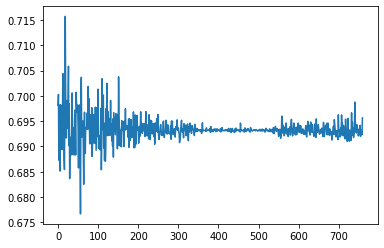

In [44]:
plt.plot([float(loss) for loss in losses])
plt.show()

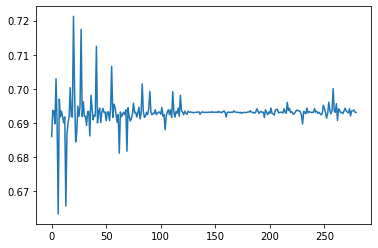

In [45]:
plt.plot([float(loss) for loss in val_losses])
plt.show()

### Visualize accuracy

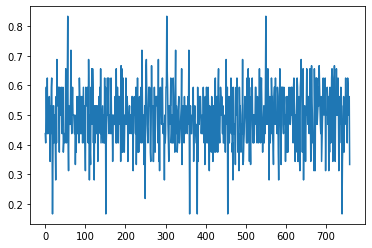

In [46]:
plt.plot([float(acc) for acc in accuracies])
plt.show()

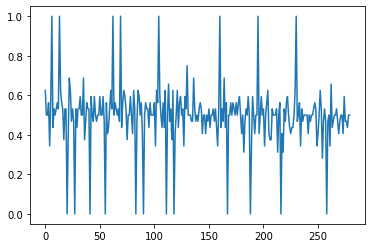

In [47]:
plt.plot([float(acc) for acc in val_accuracies])
plt.show()

### Model saving

Transformers are save automatically after creation and fitting inside raw_dataset_to_tensors function so only model should be saved manually.

In [16]:
save_module(neural_cf_model, name=NEURAL_CF)

### Future inferention optimization

In order to make inferention faster the whole preprocessing pipeline (mongo models to dataframes and dataframes to tensors) can be precalculated for all users and services in the database.

##### mongo models to dataframes precalculation

You can also calculate dataframes during creating raw dataset by passing `save_df=True` parameter to the `create_raw_dataset` function, rather than using below function.

In [17]:
%time calculate_dfs_for_users_and_services()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

CPU times: user 5.69 s, sys: 60.3 ms, total: 5.75 s
Wall time: 5.68 s


##### dataframes to tensors precalculation

In [18]:
%time calculate_tensors_for_users_and_services()

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

0it [00:00, ?it/s]

CPU times: user 1.52 s, sys: 19.8 ms, total: 1.54 s
Wall time: 1.51 s


### Inferention

Last saved transformers are automaticaly loaded by inference functions
but you can load them manually in the following way:

`user_transformer = load_last_transformer(USERS)
service_transformer = load_last_transformer(SERVICES)`

Model loading:

In [19]:
neural_cf_model = load_last_module(NEURAL_CF)

Inferention data preparing

In [20]:
user = User.objects[0]
services = list(Service.objects)
service = services[0]

##### WARNING!
transform user and service to tensors - if you precalculated dataframes and tensors before, they will be reused due to optimization

In [21]:
%%time
users_tensor, services_tensor = user_and_service_to_tensors(user, service)

CPU times: user 1.18 ms, sys: 0 ns, total: 1.18 ms
Wall time: 1.08 ms


Inference!

In [22]:
%%time
prediction = neural_cf_model(users_tensor, services_tensor).item()

CPU times: user 1.76 ms, sys: 0 ns, total: 1.76 ms
Wall time: 1.05 ms


In [23]:
print(f"Inferenced probability: {prediction}")

Inferenced probability: 0.4979735314846039


##### WARNING!
Transform user and multiple services - this function is used by recommendation endpoint and it demans dataframes and tensors precalculation

In [24]:
%%time
users_tensor, services_tensor = user_and_services_to_tensors(user, services)

CPU times: user 72.1 ms, sys: 0 ns, total: 72.1 ms
Wall time: 69.5 ms


Inference!

In [25]:
%time
predictions = neural_cf_model(users_tensor, services_tensor)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs


In [26]:
print(f"Inferenced probabilities: {predictions}")

Inferenced probabilities: tensor([[0.4980],
        [0.4980],
        [0.4979],
        [0.4980],
        [0.4981],
        [0.4980],
        [0.4980],
        [0.4981],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4979],
        [0.4980],
        [0.4979],
        [0.4980],
        [0.4980],
        [0.4981],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4979],
        [0.4980],
        [0.4979],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4981],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4979],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4978],
        [0.4980],
        [0.4980],
        [0.4981],
        [0.4980],
        [0.4981],
        [0.4980],
        [0.4980],
        [0.4980],
        [0.4979],
        [0.4980],
        [0.4980],
        [0.4981],
        [0.4980],
        [0.4979],
  

TODO: users and services RAM loading in preagent

In [ ]:
train test split